In [2]:
import numpy as np
import pandas as pd
import data_process as dp
import matplotlib.pyplot as plt
import DLEDMD
import MLP
from tensorflow.keras.callbacks import ReduceLROnPlateau

c:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
data = np.load('./databygroup.npy',allow_pickle=True).tolist()

In [3]:
sdata=data[['6-1号生物池好氧段MLSS', '6-1号生物池缺氧段MLSS', '6-1号生物池厌氧段MLSS', 
            '6-1号生物池缺氧段OPR','6-1号生物池厌氧段OPR','生物池DO','1号生物反应池瞬时流量']]
cdata=data[['好氧段曝气量','7-1外回流流量1', '内回流流量1']]
idata=data[['进水COD', '进水PH', '进水温度', '进水氨氮', '进水TP', '进水TN', '进水SS']]
odata=data[['出水COD', '出水TN', '出水TP', '出水氨氮', '出水NO3-']]

# Reconstruct training and test data

In [4]:
t_sDATA,maxd,mind=dp.normlize_F(sdata.values)
t_cDATA,maxd,mind=dp.normlize_F(cdata.values)
t_iDATA,maxd,mind=dp.normlize_F(idata.values)
t_oDATA,maxd,mind=dp.normlize_F(odata.values)

In [5]:
sTrain,cTrain,iTrain,oTrain,oTrain_out=[],[],[],[],[]
HRT=84 # time=7 hour, equal to 84 steps
outstep=6 # predict 30 min, equal to 6 steps
n=data.shape[0]
for i in range(HRT+10,n-outstep):
    sTrain.append(t_sDATA[i-HRT:i,:].reshape((1,-1))[0].tolist())
    cTrain.append(t_cDATA[i-HRT:i,:].reshape((1,-1))[0].tolist())
    iTrain.append(t_iDATA[i-HRT:i,:].reshape((1,-1))[0].tolist())
    oTrain.append(t_oDATA[i,:].tolist())
    oTrain_out.append(t_oDATA[i+outstep,:].tolist())
sTrain=np.array(sTrain)
cTrain=np.array(cTrain)
iTrain=np.array(iTrain)
oTrain=np.array(oTrain)
oTrain_out=np.array(oTrain_out)

In [7]:
# save data
np.save('sTrain.npy',sTrain)
np.save('cTrain.npy',cTrain)
np.save('iTrain.npy',iTrain)
np.save('oTrain.npy',oTrain)
np.save('oTrain_out.npy',oTrain_out)

In [6]:
params = {
            's_input_shape': sTrain.shape[1], 
            'c_input_shape': cTrain.shape[1], 
            'i_input_shape': iTrain.shape[1],
            'o_input_shape': oTrain.shape[1],
            'snet_layer': 3,
            's_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'cnet_layer': 3,
            'c_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'inet_layer': 3,
            'i_net': [{'num': 50}, {'num': 50},  {'num': 50}],
            'Encoding_layer': 4,
            'Encoding_param': [{'num': 50} for _ in range(4)],
            'Output_layer': 6,
            'Output_param': [{'num': 50} for _ in range(5)] + [{'num': oTrain_out.shape[1]}],
            'training_data_num': n-outstep-HRT-10
        }

In [7]:
mmd='DLEDMD_net'
inlr=1e-4
if mmd=='DLEDMD_net':
    model=DLEDMD.DLEDMD_net(params)
else:
    model=MLP.MLP_net(params)
model.build_net(inlr)

In [8]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s_input (InputLayer)            [(None, 588)]        0                                            
__________________________________________________________________________________________________
c_input (InputLayer)            [(None, 252)]        0                                            
__________________________________________________________________________________________________
snet_0 (Dense)                  (None, 50)           29450       s_input[0][0]                    
__________________________________________________________________________________________________
cnet_0 (Dense)                  (None, 50)           12650       c_input[0][0]                    
______________________________________________________________________________________________

In [10]:
step=5
r=[]
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1)
history=model.model.fit(x=[sTrain,cTrain,iTrain,oTrain], y=[oTrain_out],epochs=step,verbose=0,callbacks=[reduce_lr])
model.model.save('./Results/' + mmd + '/model_v1.h5')
r+=hist.history['loss']
np.save('./Results/' + mmd + '/model_train1.npy', r)

NameError: name 'r' is not defined

In [13]:
r=[]
r+=history.history['loss']

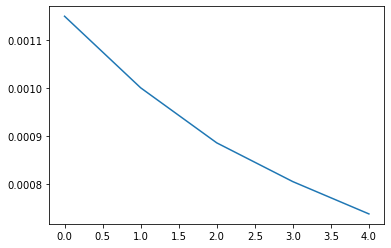

In [16]:
plt.figure()
plt.plot(r)
plt.savefig('./Results/' + mmd + '/train_error_1.tif')